In [34]:
import os, math
from collections import defaultdict
import itertools
import sqlite3

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdv import *

In [35]:
config = Config('SQLITE3')
RNG = np.random.default_rng()

if cp.cuda.is_available():
    device_marker = cp.empty(1)
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    device_marker = np.empty(1)
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
xp = cp.get_array_module(device_marker)
print(f'xp = {xp.__name__}')

train_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.train_db_file_name))
test_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.test_db_file_name))

xp = cupy


In [36]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 3 μs, sys: 1 μs, total: 4 μs
Wall time: 6.44 μs


((10000, 3), (2000, 3))

In [37]:
df_train_images.head()

,index,value,png
image_id,,,
27456,0,2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
50770,1,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
9353,2,4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
50328,3,0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
18785,4,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


In [38]:
df_first_encoding = pd.read_sql_query('SELECT * FROM image_encodings LIMIT 1', con=train_db_con)
assert len(df_first_encoding) > 0
IMAGE_ENCODING_DIMS = np.frombuffer(df_first_encoding.iloc[0]['data'], dtype='b').shape[0]
assert IMAGE_ENCODING_DIMS > 0
IMAGE_ENCODING_DIMS

4096

In [39]:
def matrix_to_image(m):
    m = m.ravel()
    sz = int(np.sqrt(m.shape[0]))
    assert sz * sz == m.shape[0]
    return Image.frombytes('L', size=(sz, sz), data=m.astype('b'))

In [40]:
def lay_grid(image, step):
    draw = ImageDraw.Draw(image)

    for c in range(step - 1, image.height, step):
        draw.line([0, c, image.width, c], fill=127)
        draw.line([c, 0, c, image.height], fill=127)

    return image


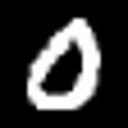
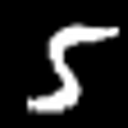
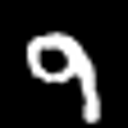
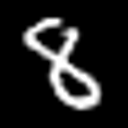
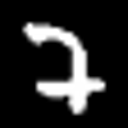
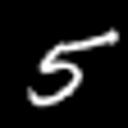
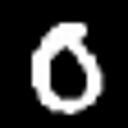
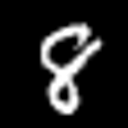
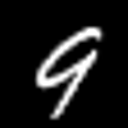
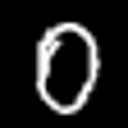
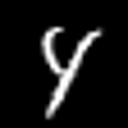
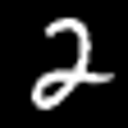
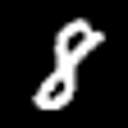
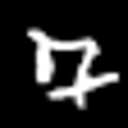
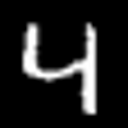
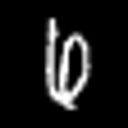

In [41]:
count = 8

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    image_datas = df.loc[image_ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[image_ids]['value']
    return images, list(labels)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [122]:
#COS_SIM_THRESHOLD = 0.075
COS_SIM_THRESHOLD = 0.055
hdv = Hdv(10_000, np)

In [123]:
def generate_permutation_matrix(input_vector_dims):
    pm = np.zeros((input_vector_dims, input_vector_dims), dtype='b')
    row_indices = RNG.choice(pm.shape[0], pm.shape[0], replace=False)
    
    for row_index, column_index in zip(row_indices, range(pm.shape[1])):
        pm[row_index, column_index] = 1

    return pm

In [124]:
pm = generate_permutation_matrix(100)
assert np.array_equal((pm == 1).sum(axis=0), np.ones(pm.shape[0]))
assert np.array_equal((pm == 1).sum(axis=1), np.ones(pm.shape[0]))
rand_vec = RNG.integers(0, 2, pm.shape[0])
mutated_rand_vec = pm @ rand_vec
assert np.array_equal(pm.T @ mutated_rand_vec, rand_vec)
assert np.array_equal(np.unique_counts(rand_vec).counts, np.unique_counts(mutated_rand_vec).counts)

In [125]:
class CorticalColumn(object):
    def __init__(self, input_vector_dims, stride_width, strides_count):
        #self.input_vector_permutation2 = generate_permutation_matrix(input_vector_dims)
        self.stride_width = stride_width
        self.stride_hdvs = defaultdict(hdv)

        assert input_vector_dims >= stride_width
        total_strides = input_vector_dims // stride_width
        assert strides_count <= total_strides
        self.stride_indices = RNG.choice(total_strides, strides_count, replace=False)
        self.stride_indices *= stride_width
        assert np.all(np.unique_counts(self.stride_indices).counts == 1)

        self.bundles = dict()
        self.bundle_to_image_ids = defaultdict(set)
        self.bundles_norm = HdvArray(hdv.N, np)

    def bundle_input_vectors(self, input_vectors):
        bundle = []

        for input_vector in input_vectors:
            input_vector_hdv = []
            
            for stride_index in self.stride_indices:
                stride = input_vector[stride_index:stride_index + self.stride_width]
    
                if np.all(stride == 0):
                    continue
                    
                stride_code = ''.join(map(str, stride.tolist()))
                stride_hdv = self.stride_hdvs[stride_code]
                stride_hdv = hdv.shift(stride_hdv, stride_index)
                input_vector_hdv.append(stride_hdv)
    
            if not input_vector_hdv:
                continue

            input_vector_hdv = hdv.bundle(input_vector_hdv)
            bundle.append(input_vector_hdv)

        if not bundle:
            return None

        return hdv.bundle(bundle) if len(bundle) > 1 else bundle[0]

In [126]:
stride_width = 16
COLUMN = CorticalColumn(IMAGE_ENCODING_DIMS, stride_width, IMAGE_ENCODING_DIMS // stride_width)

In [135]:
stride_width = 16
COLUMN = CorticalColumn(IMAGE_ENCODING_DIMS, stride_width, IMAGE_ENCODING_DIMS // stride_width)
df_train_progress = pd.DataFrame(columns=['count', 'infers', 'correct_infers'])

trials = 10
count = 100

for trials in tqdm(range(trials)):
    # TRAIN STEP
    train_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    for image_id in tqdm(train_step_image_ids, leave=False):
        image_value = df_train_images.loc[image_id]['value']
        df_image_encodings = pd.read_sql(f'SELECT data FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=train_db_con)
        assert len(df_image_encodings) > 0
        image_encodings = list(map(lambda d: np.frombuffer(d, dtype='b'), df_image_encodings['data']))
        image_bundle = COLUMN.bundle_input_vectors(image_encodings)
        assert not image_bundle is None
        image_bundle_norm = hdv.normalize(image_bundle)
        cos_sims = COLUMN.bundles_norm.array @ image_bundle_norm
        cos_sims_indices = np.argwhere(cos_sims >= COS_SIM_THRESHOLD).reshape(-1)
        sorted_cos_sims_with_indices = sorted(zip(cos_sims[cos_sims_indices], cos_sims_indices), key=lambda x: -x[0]) # sort by cos sim desc

        # Debundle from ALL clusters which showed similarity but actually are not
        for _, index in sorted_cos_sims_with_indices:
            similar_bundle = COLUMN.bundles[index]
            similar_bundle_image_ids = COLUMN.bundle_to_image_ids[index]
            assert len(similar_bundle_image_ids) > 0
            similar_bundle_image_ids = next(iter(similar_bundle_image_ids)) # pick any
            similar_bundle_image_value = df_train_images.loc[similar_bundle_image_ids]['value']

            if similar_bundle_image_value != image_value:
                similar_bundle[:] = hdv.debundle(similar_bundle, image_bundle)
                COLUMN.bundles_norm.array[index] = hdv.normalize(similar_bundle)

        # Bundle with MOST successive one
        for _, index in sorted_cos_sims_with_indices:
            similar_bundle = COLUMN.bundles[index]
            similar_bundle_image_ids = COLUMN.bundle_to_image_ids[index]
            assert len(similar_bundle_image_ids) > 0
            similar_bundle_image_id = next(iter(similar_bundle_image_ids)) # pick any
            similar_bundle_image_value = df_train_images.loc[similar_bundle_image_id]['value']

            if similar_bundle_image_value == image_value:
                similar_bundle[:] = hdv.bundle(similar_bundle, image_bundle)
                COLUMN.bundles_norm.array[index] = hdv.normalize(similar_bundle)
                similar_bundle_image_ids.add(image_id)
                break # there must be only one
        else:
            # Didn't find any matching bundle of HDVs to join -> create new one
            index = COLUMN.bundles_norm.lease()
            COLUMN.bundles_norm.array[index] = image_bundle_norm
            assert np.array_equal(COLUMN.bundles_norm.array[index], image_bundle_norm)
            COLUMN.bundles[index] = image_bundle
            COLUMN.bundle_to_image_ids[index].add(image_id)

    # CONSOLIDATE MEMORY
    before_len = COLUMN.bundles_norm.len()
    assert before_len == len(COLUMN.bundles)
    bundle_indices_to_release = []
    
    for bundle_index, image_ids in COLUMN.bundle_to_image_ids.items():
        if len(image_ids) <= 1:
            bundle_indices_to_release.append(bundle_index)

    for bundle_index_to_release in bundle_indices_to_release:
        del COLUMN.bundles[bundle_index_to_release]
        del COLUMN.bundle_to_image_ids[bundle_index_to_release]
        COLUMN.bundles_norm.release(bundle_index_to_release)

    # INFER STEP
    inference_count = 0
    correct_inference_count = 0
    infer_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    for image_id in tqdm(infer_step_image_ids, leave=False):
        image_value = df_train_images.loc[image_id]['value']
        df_image_encodings = pd.read_sql(f'SELECT data FROM image_encodings WHERE image_id=:image_id LIMIT 1', params={'image_id': int(image_id)}, con=train_db_con)
        assert len(df_image_encodings) == 1
        image_encoding = df_image_encodings.iloc[0]['data']
        image_encoding = np.frombuffer(image_encoding, dtype='b')
        image_bundle = COLUMN.bundle_input_vectors([image_encoding])
        assert not image_bundle is None
        image_bundle_norm = hdv.normalize(image_bundle)
        cos_sims = COLUMN.bundles_norm.array @ image_bundle_norm
        max_cos_sim_index = np.argmax(cos_sims)

        if cos_sims[max_cos_sim_index] <= COS_SIM_THRESHOLD:
            continue
            
        inference_count += 1

        similar_bundle_image_ids = COLUMN.bundle_to_image_ids[max_cos_sim_index]
        assert len(similar_bundle_image_ids) > 0
        similar_bundle_image_id = next(iter(similar_bundle_image_ids))
        similar_bundle_image_value = df_train_images.loc[similar_bundle_image_id]['value']
        
        is_correct_infer = similar_bundle_image_value == image_value
        correct_inference_count += int(is_correct_infer)
        
    df_train_progress.loc[len(df_train_progress)] = [count, inference_count, correct_inference_count]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

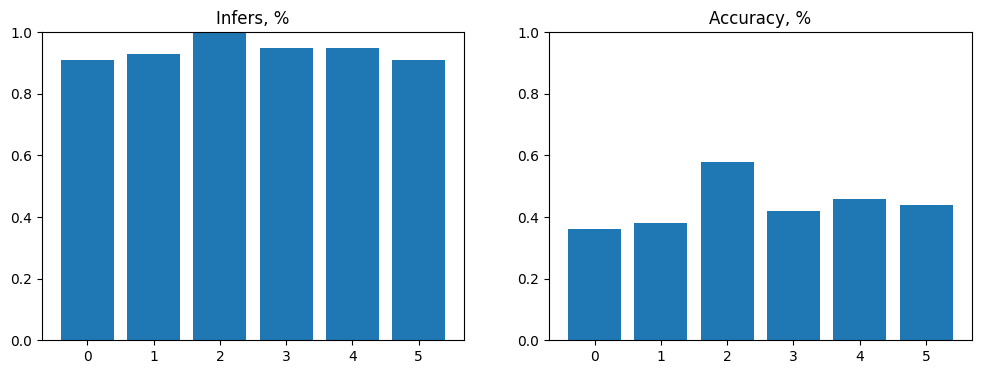

In [150]:
df_train_progress_2 = df_train_progress.copy()
df_train_progress_2['infer_ratio'] = df_train_progress_2['infers'] / df_train_progress_2['count']
df_train_progress_2['accuracy'] = df_train_progress_2['correct_infers'] / df_train_progress_2['count']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(list(df_train_progress_2.index), list(df_train_progress_2['infer_ratio']))
plt.ylim(0, 1)
plt.title('Infers, %')

plt.subplot(1, 2, 2)
plt.bar(list(df_train_progress_2.index), list(df_train_progress_2['accuracy']))
plt.ylim(0, 1)
plt.title('Accuracy, %')
plt.grid()

plt.show()
df_train_progress

In [151]:
stride_width = 16
COLUMN = CorticalColumn(IMAGE_ENCODING_DIMS, stride_width, IMAGE_ENCODING_DIMS // stride_width)
df_train_progress = pd.DataFrame(columns=['count', 'infers', 'correct_infers'])

trials = 10
count = 100

for trials in tqdm(range(trials)):
    # TRAIN STEP
    train_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    for image_id in tqdm(train_step_image_ids, leave=False):
        image_value = df_train_images.loc[image_id]['value']
        df_image_encodings = pd.read_sql(f'SELECT data FROM image_encodings WHERE image_id=:image_id LIMIT 1', params={'image_id': int(image_id)}, con=train_db_con)
        assert len(df_image_encodings) == 1
        image_encoding = df_image_encodings.iloc[0]['data']
        image_encoding = np.frombuffer(image_encoding, dtype='b')
        image_bundle = COLUMN.bundle_input_vectors([image_encoding])
        assert not image_bundle is None
        image_bundle_norm = hdv.normalize(image_bundle)
        cos_sims = COLUMN.bundles_norm.array @ image_bundle_norm
        cos_sims_indices = np.argwhere(cos_sims >= COS_SIM_THRESHOLD).reshape(-1)
        sorted_cos_sims_with_indices = sorted(zip(cos_sims[cos_sims_indices], cos_sims_indices), key=lambda x: -x[0]) # sort by cos sim desc

        # Debundle from ALL clusters which showed similarity but actually are not
        for _, index in sorted_cos_sims_with_indices:
            similar_bundle = COLUMN.bundles[index]
            similar_bundle_image_ids = COLUMN.bundle_to_image_ids[index]
            assert len(similar_bundle_image_ids) > 0
            similar_bundle_image_ids = next(iter(similar_bundle_image_ids)) # pick any
            similar_bundle_image_value = df_train_images.loc[similar_bundle_image_ids]['value']

            if similar_bundle_image_value != image_value:
                similar_bundle[:] = hdv.debundle(similar_bundle, image_bundle)
                COLUMN.bundles_norm.array[index] = hdv.normalize(similar_bundle)

        # Bundle with MOST successive one
        for _, index in sorted_cos_sims_with_indices:
            similar_bundle = COLUMN.bundles[index]
            similar_bundle_image_ids = COLUMN.bundle_to_image_ids[index]
            assert len(similar_bundle_image_ids) > 0
            similar_bundle_image_id = next(iter(similar_bundle_image_ids)) # pick any
            similar_bundle_image_value = df_train_images.loc[similar_bundle_image_id]['value']

            if similar_bundle_image_value == image_value:
                similar_bundle[:] = hdv.bundle(similar_bundle, image_bundle)
                COLUMN.bundles_norm.array[index] = hdv.normalize(similar_bundle)
                similar_bundle_image_ids.add(image_id)
                break # there must be only one
        else:
            # Didn't find any matching bundle of HDVs to join -> create new one
            index = COLUMN.bundles_norm.lease()
            COLUMN.bundles_norm.array[index] = image_bundle_norm
            assert np.array_equal(COLUMN.bundles_norm.array[index], image_bundle_norm)
            COLUMN.bundles[index] = image_bundle
            COLUMN.bundle_to_image_ids[index].add(image_id)

    # CONSOLIDATE MEMORY
    before_len = COLUMN.bundles_norm.len()
    assert before_len == len(COLUMN.bundles)
    bundle_indices_to_release = []
    
    for bundle_index, image_ids in COLUMN.bundle_to_image_ids.items():
        if len(image_ids) <= 1:
            bundle_indices_to_release.append(bundle_index)

    for bundle_index_to_release in bundle_indices_to_release:
        del COLUMN.bundles[bundle_index_to_release]
        del COLUMN.bundle_to_image_ids[bundle_index_to_release]
        COLUMN.bundles_norm.release(bundle_index_to_release)

    # INFER STEP
    inference_count = 0
    correct_inference_count = 0
    infer_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    for image_id in tqdm(infer_step_image_ids, leave=False):
        image_value = df_train_images.loc[image_id]['value']
        df_image_encodings = pd.read_sql(f'SELECT data FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=train_db_con)
        assert len(df_image_encodings) > 0
        image_encodings = list(map(lambda d: np.frombuffer(d, dtype='b'), df_image_encodings['data']))

        for image_encoding in image_encodings:
            image_bundle = COLUMN.bundle_input_vectors([image_encoding])
            assert not image_bundle is None
            image_bundle_norm = hdv.normalize(image_bundle)
            cos_sims = COLUMN.bundles_norm.array @ image_bundle_norm
            max_cos_sim_index = np.argmax(cos_sims)
    
            if cos_sims[max_cos_sim_index] <= COS_SIM_THRESHOLD:
                continue
                
            inference_count += 1
    
            similar_bundle_image_ids = COLUMN.bundle_to_image_ids[max_cos_sim_index]
            assert len(similar_bundle_image_ids) > 0
            similar_bundle_image_id = next(iter(similar_bundle_image_ids))
            similar_bundle_image_value = df_train_images.loc[similar_bundle_image_id]['value']
            
            is_correct_infer = similar_bundle_image_value == image_value
            correct_inference_count += int(is_correct_infer)
            break
        
    df_train_progress.loc[len(df_train_progress)] = [count, inference_count, correct_inference_count]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

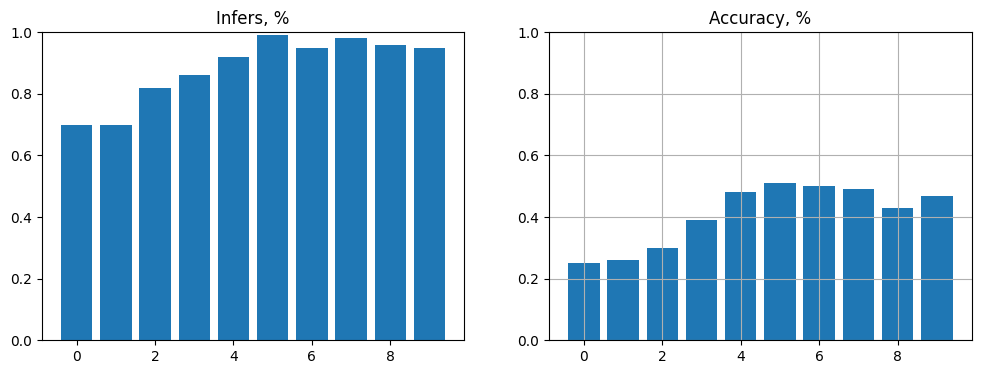

,count,infers,correct_infers
0,100,70,25
1,100,70,26
2,100,82,30
3,100,86,39
4,100,92,48
5,100,99,51
6,100,95,50
7,100,98,49
8,100,96,43
9,100,95,47


In [154]:
df_train_progress_2 = df_train_progress.copy()
df_train_progress_2['infer_ratio'] = df_train_progress_2['infers'] / df_train_progress_2['count']
df_train_progress_2['accuracy'] = df_train_progress_2['correct_infers'] / df_train_progress_2['count']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(list(df_train_progress_2.index), list(df_train_progress_2['infer_ratio']))
plt.ylim(0, 1)
plt.title('Infers, %')

plt.subplot(1, 2, 2)
plt.bar(list(df_train_progress_2.index), list(df_train_progress_2['accuracy']))
plt.ylim(0, 1)
plt.title('Accuracy, %')
plt.grid()

plt.show()
df_train_progress

,count,infers,correct_infers
0,100,70,25
1,100,70,26
2,100,82,30
3,100,86,39
4,100,92,48
5,100,99,51
6,100,95,50
7,100,98,49
8,100,96,43
9,100,95,47


[]

In [141]:
cos_sims

array([-0.00816717,  0.00302482, -0.00960694, ...,  0.        ,
        0.        ,  0.        ])

In [85]:
cos_sims = column.norm_hdvs.array @ column_norm_hdv
#print(f'{(cos_sims != 0).sum()}')
norm_hdv_indices = np.argwhere(cos_sims >= COS_SIM_THRESHOLD).reshape(-1)

In [84]:
norm_hdv_indices

array([ 1,  2,  5,  9, 11, 12, 13, 14, 16, 31, 34, 38, 39, 41, 43, 44, 45,
       49, 51, 63, 70, 77, 78])

In [86]:
cos_sims[norm_hdv_indices]

array([0.14, 1.92, 0.8 , 1.96, 2.24, 0.86, 8.1 , 1.02, 0.86, 2.2 , 1.84,
       0.8 , 1.48, 2.16, 0.3 , 2.12, 3.18, 2.36, 2.48, 0.14, 2.32, 1.02,
       3.94])

In [106]:
int(RNG.choice([True, False]))

0

In [ ]:
column_norm_hdv

In [ ]:
a1 = np.arange(10)
a1[:] = 0
a1

In [ ]:
# Consolidate memory
for column in CORTICAL_COLUMNS:
    for norm
    if column.stage_norm_hdvs:
        offset = column.conso_norm_hdvs.shape[0]
        offsetted_mapping = map(lambda p: (p[0] + offset, p[1]), column.stage_norm_hdv_index_to_image_id.items())
        column.conso_norm_hdvs = np.append(column.conso_norm_hdvs, column.stage_norm_hdvs, axis=0)
        column.conso_norm_hdv_index_to_image_id.update(offsetted_mapping)

    column.stage_norm_hdvs = []
    column.stage_norm_hdv_index_to_image_index = dict()

In [ ]:
НАДО КАК_ТО мерить успещность сортировки

In [ ]:
# Consolidate memory
for column in CORTICAL_COLUMNS:
    if column.stage_norm_hdvs:
        offset = column.conso_norm_hdvs.shape[0]
        offsetted_mapping = map(lambda p: (p[0] + offset, p[1]), column.stage_norm_hdv_index_to_image_id.items())
        column.conso_norm_hdvs = np.append(column.conso_norm_hdvs, column.stage_norm_hdvs, axis=0)
        column.conso_norm_hdv_index_to_image_id.update(offsetted_mapping)

    column.stage_norm_hdvs = []
    column.stage_norm_hdv_index_to_image_index = dict()

In [ ]:
column = CORTICAL_COLUMNS[0]
cross_sim = column.conso_norm_hdvs @ column.conso_norm_hdvs.T
cross_sim_tril = np.tril(cross_sim, -1)
indices = np.argwhere(cross_sim_tril >= COS_SIM_THRESHOLD)
df = pd.DataFrame(columns=['i', 'j', 'i_image_id', 'j_image_jd', 'sim'])

for ij in indices:
    i = ij[0]
    j = ij[1]
    sim = cross_sim_tril[i,j]
    assert sim >= COS_SIM_THRESHOLD
    i_image_id = column.conso_norm_hdv_index_to_image_id[i]
    j_image_id = column.conso_norm_hdv_index_to_image_id[j]
    df.loc[len(df)] = [i, j, i_image_id, j_image_id, sim]



In [ ]:
df['sim_cat'] = pd.cut(df['sim'], 10)

In [ ]:
df_pivot = pd.pivot_table(df, index=['sim_cat'], values=['sim'], aggfunc=['count'], observed=False)
df_pivot

In [ ]:
plt.plot(list(map(str, df_pivot.index)), list(df_pivot[('count', 'sim')]))
plt.grid()
plt.show()

In [ ]:
def get_consensus_table(image_encoding):
    table = defaultdict(list)
    #image_encoding_for_columns = CORTICAL_COLUMNS_PMS @ image_encoding # Permutation is very expensive. On CPU slowdown is 13 times!
    image_encoding_for_columns = map(lambda _: image_encoding, CORTICAL_COLUMNS)
    
    for column_index, (column, image_encoding_for_column) in enumerate(zip(CORTICAL_COLUMNS, image_encoding_for_columns)):
        column_norm_hdv = []
    
        for stride_index in column.stride_indices:
            stride = image_encoding_for_column[stride_index:stride_index + column.stride_width]

            if np.all(stride == 0):
                continue

            stride_code = ''.join(map(str, stride.tolist()))
            stride_hdv = column.stride_hdvs[stride_code]
            stride_hdv = hdv.shift(stride_hdv, stride_index)
            column_norm_hdv.append(stride_hdv)

        if not column_norm_hdv:
            continue
            
        column_norm_hdv = hdv.bundle_noties(column_norm_hdv)
        column_norm_hdv = hdv.normalize(column_norm_hdv)
    
        cos_sims = column.conso_norm_hdvs @ column_norm_hdv # this will compute cos sim against all HDVs
        candidate_hdv_indices = np.argwhere(cos_sims >= COS_SIM_THRESHOLD).reshape(-1)

        for candidate_hdv_index in candidate_hdv_indices:
            cos_sim = cos_sims[candidate_hdv_index]
            candidate_image_id = column.conso_norm_hdv_index_to_image_id[candidate_hdv_index]
            table['column_index'].append(column_index)
            table['image_id'].append(candidate_image_id)
            table['sim'].append(cos_sim)

    return table

In [ ]:
%%time
count = 100
images_row = []
image_protos_rows = [[], [], []]
images_captions = []
image_protos_captions = [[], [], []]
inference_table = []

def get_image_safe(df, image_id):
    if image_id < 0:
        return Image.new('L', size=(1,1), color=255)

    image_data = df.loc[image_id]['png']
    return Image.open(io.BytesIO(image_data))

test_image_ids = RNG.choice(df_test_images.index.unique(), count, replace=False)
    
for image_id in tqdm(test_image_ids):
    images_row.append(image_id)
    true_value = df_test_images.loc[image_id]['value']
    images_captions.append(f'#{image_id}, val={true_value}')
    
    inference_record = [image_id, int(true_value)]
    df_encodings = pd.read_sql(f'SELECT * FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=test_db_con)
    
    for _, df_encoding_row in df_encodings.iterrows():
        image_variant_encoding = np.frombuffer(df_encoding_row['data'], dtype='b')
        consensus_table = get_consensus_table(image_variant_encoding)

        if len(consensus_table) == 0:
            continue

        consensus_table = pd.DataFrame(consensus_table, columns=['column_index', 'image_id', 'sim'])
        assert len(consensus_table) > 0
        image_protos = pd.pivot_table(consensus_table, 
                                      index=['image_id'], 
                                      values=['sim', 'column_index'], 
                                      aggfunc={'sim': 'sum', 'column_index': 'nunique'},
                                      sort=False)
        image_protos = image_protos[(image_protos[('column_index')] >= len(CORTICAL_COLUMNS) * 0.75)]
        image_protos.sort_values(by=['column_index', 'sim'], ascending=[False, False], inplace=True)

        if len(image_protos) > 0:
            break
    else:
        image_protos = pd.DataFrame(columns=['dummy'])

    for row, captions, image_proto in itertools.zip_longest(image_protos_rows, image_protos_captions, image_protos.iterrows()):
        if row is None:
            break
            
        image_proto_id, votes, cos_sim = (-1, 0, 0) if image_proto is None else (int(image_proto[0]), int(image_proto[1]['column_index']), image_proto[1]['sim'])
        row.append(image_proto_id)
        inferred_value = int(df_train_images.loc[image_proto_id]['value']) if image_proto_id >= 0 else -1
        captions.append(f'#{image_proto_id}, votes={votes}, sim={cos_sim:.2f}, val={inferred_value}')

        if len(inference_record) < 3:
            inference_record.append(inferred_value)

    inference_table.append(inference_record)

test_images = list(map(lambda image_id: get_image_safe(df_test_images, image_id), images_row))
train_images = list(map(lambda image_id: get_image_safe(df_train_images, image_id), itertools.chain.from_iterable(image_protos_rows)))
df = pd.DataFrame(inference_table, columns=['test_image_id', 'true value', 'infer. value'])
df['is_match'] = df['true value'] == df['infer. value']
print(f'ACCURACY = {df['is_match'].sum() / len(df) * 100:.2f}% (matched {df['is_match'].sum()} of {len(df)})')
df.head()

In [ ]:
display_images_grid(test_images+train_images,
                    col_count=count, 
                    captions=images_captions + list(itertools.chain.from_iterable(image_protos_captions)))